# **Machine Learning for diabetes classification: Naive bayes model**
This project is a machine learning model to classify diabetes.
The database used is relatively small (only 390 people) and unbalanced (about 90% are not diabetic). So the challenge was to correctly adjust the database in order to mitigate these problems.

The diabetes database: https://www.kaggle.com/houcembenmansour/predict-diabetes-based-on-diagnostic-measures



---


# **Exploring the Data**
All libraries are imported, the database is loaded and analysed.

In [1]:
#Importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from yellowbrick.classifier import ConfusionMatrix
from imblearn.combine import SMOTETomek

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported f

In [2]:
#Load file from local machine
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving diabetes.csv to diabetes.csv
User uploaded file "diabetes.csv" with length 29372 bytes


In [3]:
#Transforming to a dataframe df
df = pd.read_csv('diabetes.csv', index_col=0)
#Substitute the ',' with '.'
df=(df.replace(',',".", regex = True))
df.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
patient_number,,,,,,,,,,,,,,,
1,193,77,49,3.9,19,female,61,119,22.5,118,70,32,38,0.84,No diabetes
2,146,79,41,3.6,19,female,60,135,26.4,108,58,33,40,0.83,No diabetes
3,217,75,54,4,20,female,67,187,29.3,110,72,40,45,0.89,No diabetes
4,226,97,70,3.2,20,female,64,114,19.6,122,64,31,39,0.79,No diabetes
5,164,91,67,2.4,20,female,70,141,20.2,122,86,32,39,0.82,No diabetes


In [4]:
#Checking for empty values
df.isna().sum()

cholesterol        0
glucose            0
hdl_chol           0
chol_hdl_ratio     0
age                0
gender             0
height             0
weight             0
bmi                0
systolic_bp        0
diastolic_bp       0
waist              0
hip                0
waist_hip_ratio    0
diabetes           0
dtype: int64

No empty values found.

In [5]:
df

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
patient_number,,,,,,,,,,,,,,,
1,193,77,49,3.9,19,female,61,119,22.5,118,70,32,38,0.84,No diabetes
2,146,79,41,3.6,19,female,60,135,26.4,108,58,33,40,0.83,No diabetes
3,217,75,54,4,20,female,67,187,29.3,110,72,40,45,0.89,No diabetes
4,226,97,70,3.2,20,female,64,114,19.6,122,64,31,39,0.79,No diabetes
5,164,91,67,2.4,20,female,70,141,20.2,122,86,32,39,0.82,No diabetes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,227,105,44,5.2,83,female,59,125,25.2,150,90,35,40,0.88,No diabetes
387,226,279,52,4.3,84,female,60,192,37.5,144,88,41,48,0.85,Diabetes
388,301,90,118,2.6,89,female,61,115,21.7,218,90,31,41,0.76,No diabetes


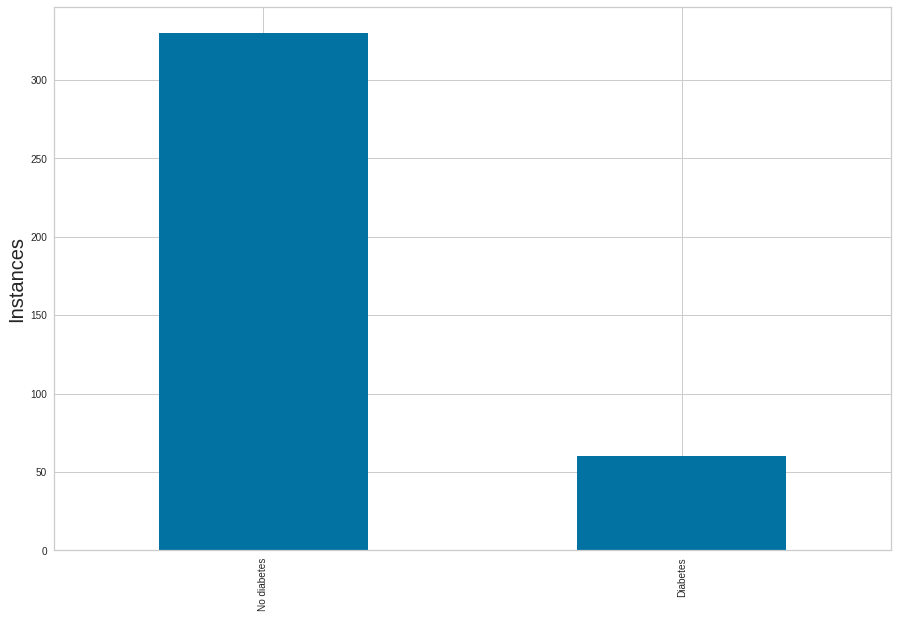

In [6]:
#Showing the distribution of the classes
da=df['diabetes'].value_counts()
plt.figure(figsize=(15,10))
plt.ylabel('Instances', size=20) 
da.plot(kind="bar")

The database is unbalanced and the machine learning will not perform well. Don't worry, the total number of 'Diabetes' instances will be increased with oversampling.


# **Plotting the Correlation Matrix**
Which variables have correlation with 'diabetes'? The correlation matrix can be used to visualize the answer. But first, all non-numeric values must be converted to numeric through the Labelenconder function.

In [7]:
#LabelEnconder (numeric conversion of string values)
x = df.iloc[:,0:14].values
y = df.iloc[:, [14]].values
labelencoder = LabelEncoder()
x[:,5] = labelencoder.fit_transform(x[:,5])
y[:,0] = labelencoder.fit_transform(y[:,0])
y=y.astype(int)

In [8]:
Remove_col='diabetes'
colunas=list(df.columns.values)
colunas.remove(Remove_col)
colunas
dfs = pd.DataFrame(x, columns=colunas)
dfs
dfc=pd.DataFrame(y, columns=['diabetes'])
dfc

,diabetes
0,1
1,1
2,1
3,1
4,1
...,...
385,1
386,0
387,1
388,0


In [9]:
#Converting type of value
a=pd.concat([dfs,dfc], axis=1)
a['chol_hdl_ratio']=a['chol_hdl_ratio'].astype(float)
a['gender']=a['gender'].astype(int)
a['bmi']=a['bmi'].astype(float)
a['waist_hip_ratio']=a['waist_hip_ratio'].astype(float)
a['diabetes']=a['diabetes'].astype(int)
for col in a.select_dtypes('object'):
        a.loc[:,col]=a[col].astype(int)  
a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cholesterol      390 non-null    int64  
 1   glucose          390 non-null    int64  
 2   hdl_chol         390 non-null    int64  
 3   chol_hdl_ratio   390 non-null    float64
 4   age              390 non-null    int64  
 5   gender           390 non-null    int64  
 6   height           390 non-null    int64  
 7   weight           390 non-null    int64  
 8   bmi              390 non-null    float64
 9   systolic_bp      390 non-null    int64  
 10  diastolic_bp     390 non-null    int64  
 11  waist            390 non-null    int64  
 12  hip              390 non-null    int64  
 13  waist_hip_ratio  390 non-null    float64
 14  diabetes         390 non-null    int64  
dtypes: float64(3), int64(12)
memory usage: 45.8 KB


In [10]:
a

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
0,193,77,49,3.9,19,0,61,119,22.5,118,70,32,38,0.84,1
1,146,79,41,3.6,19,0,60,135,26.4,108,58,33,40,0.83,1
2,217,75,54,4.0,20,0,67,187,29.3,110,72,40,45,0.89,1
3,226,97,70,3.2,20,0,64,114,19.6,122,64,31,39,0.79,1
4,164,91,67,2.4,20,0,70,141,20.2,122,86,32,39,0.82,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,227,105,44,5.2,83,0,59,125,25.2,150,90,35,40,0.88,1
386,226,279,52,4.3,84,0,60,192,37.5,144,88,41,48,0.85,0
387,301,90,118,2.6,89,0,61,115,21.7,218,90,31,41,0.76,1
388,232,184,114,2.0,91,0,61,127,24.0,170,82,35,38,0.92,0


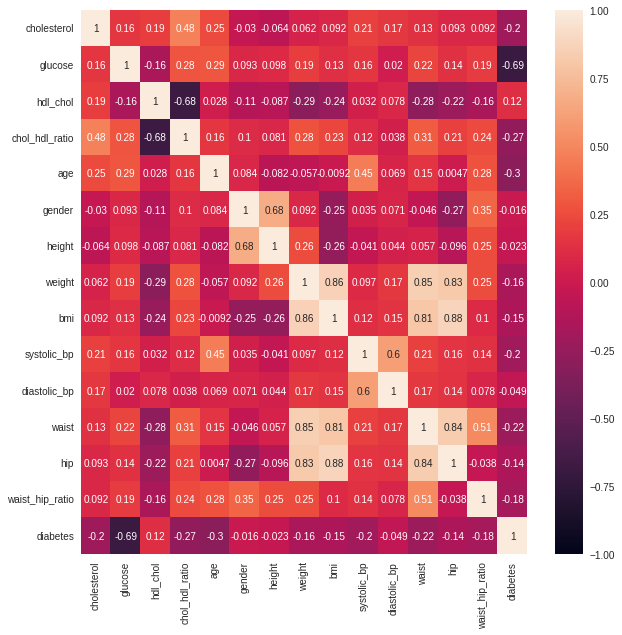

<function pandas.core.frame.DataFrame.corr>

In [11]:
#Showing the correlation matrix
corr = a.corr()
plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True, fmt='.2g', vmin=-1, vmax=+1)
plt.show()
pd.DataFrame.corr

The matrix shows a strong negative correlation between 'glucose' and 'diabetes'. 'Glucose' is the most important variable for diabetes classification. But since the rest of the variables have a similar weak correlation (with 'diabetes'), it is not clear which ones should be used.   
The selection of features will be handled by Principal Component Analysis (PCA) function.


In [12]:
df

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
patient_number,,,,,,,,,,,,,,,
1,193,77,49,3.9,19,female,61,119,22.5,118,70,32,38,0.84,No diabetes
2,146,79,41,3.6,19,female,60,135,26.4,108,58,33,40,0.83,No diabetes
3,217,75,54,4,20,female,67,187,29.3,110,72,40,45,0.89,No diabetes
4,226,97,70,3.2,20,female,64,114,19.6,122,64,31,39,0.79,No diabetes
5,164,91,67,2.4,20,female,70,141,20.2,122,86,32,39,0.82,No diabetes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,227,105,44,5.2,83,female,59,125,25.2,150,90,35,40,0.88,No diabetes
387,226,279,52,4.3,84,female,60,192,37.5,144,88,41,48,0.85,Diabetes
388,301,90,118,2.6,89,female,61,115,21.7,218,90,31,41,0.76,No diabetes




---
# **Preparing the database and Data Preprocessing**



# **Spliting the data**
It is necessary to split the dataset in two parts: training and testing.
The reason being that 'testing' data cannot be adjusted. It must remain unbalaced. Otherwise, the machine learning model would be cheating.

On the other hand, 'training' data will be going through oversampling (to increase the under-represented class).

Also, both 'training' and 'testing' data must be going through scaling and PCA to improve machine learning perfomance.

In [13]:
#Splitting the dataframe into train and test. 30% is test
x_treinamento, x_teste, y_treinamento, y_teste = train_test_split(x, y,
                                                                  test_size = 0.3,
                                                                  random_state = 24)

# **Scaling**
Scaling the data can increase machine learning performance and is needed in order to run PCA function. The StandardScaler function is used.

In [14]:
#Scaling. Fit is applied on the training data. But transform is applied on both
scalerModel = StandardScaler().fit(x_treinamento)
x_train_scaled = scalerModel.transform(x_treinamento)
x_test_scaled = scalerModel.transform(x_teste)
x_train_scaled
#x_test_scaled

array([[ 0.41538945, -0.64354928, -0.43212425, ..., -0.64294891,
        -0.66956624, -0.16303831],
       [ 2.01454969,  3.46010224,  0.46328312, ...,  0.7124569 ,
         0.88831657, -0.02937627],
       [-0.44213126, -0.44604733, -0.43212425, ...,  0.37360545,
         0.3690223 ,  0.10428577],
       ...,
       [-0.81295103,  0.45368375, -0.43212425, ..., -0.30409746,
         0.02282612, -0.56402444],
       [ 1.18020522, -0.81910656, -0.32019833, ..., -0.30409746,
         0.02282612, -0.56402444],
       [ 2.13043087, -0.31437937,  3.70913485, ..., -1.15122609,
        -0.32337006, -1.63332077]])

In [15]:
pd.DataFrame(x_train_scaled)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.415389,-0.643549,-0.432124,0.432321,-0.652218,1.189928,-1.724296,-0.160765,0.852319,0.082195,0.032945,-0.642949,-0.669566,-0.163038
1,2.014550,3.460102,0.463283,0.260107,1.574228,-0.840387,-0.718457,0.160132,0.562931,0.946988,1.176259,0.712457,0.888317,-0.029376
2,-0.442131,-0.446047,-0.432124,-0.084319,-0.291173,-0.840387,-0.969917,-0.333556,0.166927,-0.145383,0.337829,0.373605,0.369022,0.104286
3,-0.418955,-0.665494,-1.047717,0.776747,-0.471695,1.189928,1.544682,2.307676,1.202630,-0.099867,-1.034147,1.220734,1.061415,0.505272
4,-0.673894,-0.446047,0.966950,-1.060195,-0.471695,-0.840387,0.538843,2.159570,1.735713,0.173225,1.100038,0.881883,1.926905,-1.098673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,-1.485062,-0.424103,-1.271569,0.317512,-0.592044,-0.840387,-1.472837,-1.271564,-0.655544,-0.281929,-0.119496,-1.151226,-1.361959,0.104286
269,-0.836127,-0.467992,-0.823865,0.145298,-0.471695,-0.840387,-0.969917,-1.148142,-0.746930,-0.737083,-0.576822,-0.134672,-0.842664,1.173582
270,-0.812951,0.453684,-0.432124,-0.256533,1.153008,1.189928,0.538843,0.530398,0.212619,-0.873630,-0.881705,-0.304097,0.022826,-0.564024
271,1.180205,-0.819107,-0.320198,0.719343,-0.230998,-0.840387,-0.969917,-0.432294,0.060310,0.082195,0.795154,-0.304097,0.022826,-0.564024


# **Principal Component Analysis (PCA)**
Optimization. Not all variables are necessary to run the model. While using PCA, it is possible to condense the data into a smaller group of atributes while maintaining 95% of the variance (information) of the original data. 

In [16]:
#Selecting all columns
pca=PCA(n_components=14)
pca.fit(x_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=14, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [17]:
pca.explained_variance_ratio_

array([2.86221585e-01, 1.55529434e-01, 1.40709945e-01, 1.07524191e-01,
       8.20159825e-02, 7.07627929e-02, 5.84082536e-02, 4.27624240e-02,
       2.39880425e-02, 1.68666479e-02, 9.11136889e-03, 5.50506091e-03,
       4.48347126e-04, 1.45925473e-04])

<function matplotlib.pyplot.show>

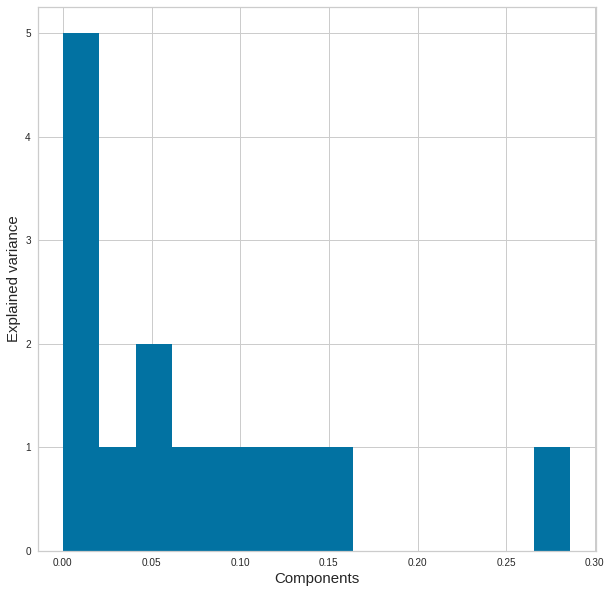

In [18]:
#Plotting the ammount of variance that each variable has
plt.figure(figsize=(10,10))
plt.hist(pca.explained_variance_ratio_, bins=14)
plt.xlabel('Components', size=15) 
plt.ylabel('Explained variance', size=15) 
plt.show

Not all variables contains significant variance.

In [19]:
#Calculating the cumulative variance
def getKComponents(pca, alpha):
  total_variance=0
  for feature, variance in enumerate(pca.explained_variance_ratio_):
    total_variance += variance
    if(total_variance >= 1 - alpha):
      return feature + 1
  return len(pca.explained_variance_ratio_)

In [20]:
#How much variables are needed to get 95% variance
K=getKComponents(pca,0.05)
K

9

In [21]:
#The resulted dataframe
x_train_scaled=pca.transform(x_train_scaled)[:,0:K]
x_test_scaled=pca.transform(x_test_scaled)[:,0:K]
pd.DataFrame(x_train_scaled)

,0,1,2,3,4,5,6,7,8
0,-0.301668,-0.361813,0.107991,0.596256,0.899577,-0.083272,-0.705480,-0.184807,2.029393
1,2.100907,1.073150,3.102378,0.801905,-0.687001,0.434342,2.205930,1.325304,0.331763
2,0.263464,-1.100593,0.345677,0.215247,0.129648,-0.690814,-0.780312,0.305243,0.000764
3,2.757590,0.337105,-2.623536,-0.454370,0.021488,0.458702,-0.204910,-1.132581,-0.245882
4,2.347132,-2.096065,-0.013789,-2.593922,0.389541,0.207531,0.917825,-0.295979,-0.354525
...,...,...,...,...,...,...,...,...,...
268,-1.882410,-0.845369,-0.173267,1.504002,0.298060,-2.093736,-1.101155,0.527485,0.236268
269,-1.165331,-0.477356,-0.439864,1.284136,-0.583089,-0.959639,-1.675809,0.839004,-0.208362
270,-0.061609,0.363364,-1.212572,0.145246,-1.065357,-0.235973,1.010460,-1.303207,0.755080
271,-0.076980,-0.707635,1.174521,0.824337,1.544140,0.372173,-0.641313,0.025850,0.149991


PCA reduced the number of dimensions of the dataset. It used to be 14. Now it is 9.


# **Oversampling**
The database is unbalanced. A solution could be to do undersampling (to delete instances of the over-represented class), but that would result in a very small dataset.

Another solution is to use SMOTE oversampling. This process creates new instances of the under-represented class instead of using copies of the original (which can cause overfitting). SMOTE oversampling is applied on the 'training' data only.

In [22]:
#Implementing Oversampling for Handling Imbalanced 
smk = SMOTETomek(random_state=42)
x_res,y_res=smk.fit_sample(x_train_scaled,y_treinamento)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [23]:
x_res.shape,y_res.shape

((462, 9), (462,))

In [24]:
from collections import Counter
#print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({1: 231, 0: 231})




---

# **Creating the model and evaluation**
The machine learning model chosen is the Naive Bayes classifier because of its ability to analyse each attribute independently.

In [25]:
#Predicting
modelo = GaussianNB()
modelo.fit(x_res, y_res)
#modelo.fit(x_treinamento, y_treinamento)
previsoes = modelo.predict(x_test_scaled)
previsoes

array([0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1])

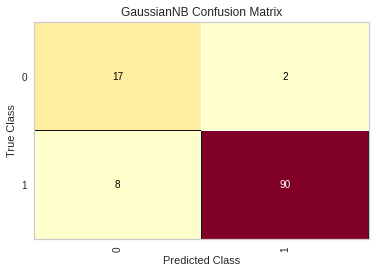

In [26]:
#Ploting the confusion Matrix
confusao = ConfusionMatrix(modelo)
confusao.fit(x_res, y_res)
#confusao.fit(x_treinamento, y_treinamento)
confusao.score(x_test_scaled, y_teste)
confusao.poof()

In [27]:
#Accuracy score
accuracy_score(y_teste, previsoes)

0.9145299145299145

Accuracy is 91%. The confusion matrix shows that the model correctly classified both 'diabetes' and 'no diabetes' classes. 